In [3]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# Wczytanie danych
data = np.genfromtxt("../../data/labels_features.csv", delimiter=",")
data = data[1:, :]

LABELS = data[:, 1].astype(int)  # Tylko klasyfikacja real/fake
FEATURES = data[:, 2:]  # Tylko cechy, bez klasyfikacji
TARGET_NAMES = ["Metastasis, class 0", "No metastasis, class 1"]

# Wrapped method

In [ ]:
# Definiowanie modelu bazowego do selekcji cech
model_rf = RandomForestClassifier(random_state=42)

# Użycie RFECV do automatycznego doboru liczby cech
selector = RFECV(estimator=model_rf, step=1, cv=5, scoring='accuracy')
FEATURES = selector.fit_transform(FEATURES, LABELS)

In [ ]:
# Podział na zbiory treningowe i testowe
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(FEATURES, LABELS, test_size=test_size, random_state=42, stratify=LABELS)

# Konwersja etykiet do formatu kategorycznego
num_labels = len(np.unique(LABELS))
y_cat_train = to_categorical(y_train, num_labels)
y_cat_test = to_categorical(y_test, num_labels)

# Skalowanie cech
scaler_object = MinMaxScaler()
scaler_object.fit(x_train)
x_train = scaler_object.transform(x_train)
x_test = scaler_object.transform(x_test)

# Przekształcenie cech dla modelu
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

x_train_shape = x_train[0].shape
x_test_shape = x_test[0].shape

In [4]:
from sklearn.metrics import f1_score
from keras.backend import epsilon
from tensorflow import cast, round, float32, reduce_sum


def f1_score(y_true, y_pred):
    y_true = cast(y_true, float32)
    y_pred = cast(
        round(y_pred), float32
    )  # Zakładamy, że y_pred jest wartościami kontinuacyjnymi, a nie binarnymi

    TP = reduce_sum(y_true * y_pred)
    FP = reduce_sum(y_pred) - TP
    FN = reduce_sum(y_true) - TP

    precision = TP / (TP + FP + epsilon())
    recall = TP / (TP + FN + epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + epsilon())

    return f1


from keras.layers import Normalization, Input, BatchNormalization, Reshape

normalizer = Normalization()
# normalizer.adapt(FEATURES)
normalizer.adapt(x_train)

model = Sequential()
model.add(Input(shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Reshape((x_train.shape[1], 1)))

model.add(Conv1D(216, 1, activation="relu"))

# model.add(MaxPooling1D())

model.add(Conv1D(80, 1, activation="relu"))
model.add(Conv1D(421, 1, activation="relu"))
model.add(Conv1D(137, 1, activation="relu"))

# model.add(MaxPooling1D())

model.add(Flatten())

model.add(Dropout(0.15650063875581377))
model.add(Dense(199, activation="relu"))
model.add(Dropout(0.15650063875581377))
model.add(Dense(64, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[f1_score])

epochs = 300
withVal = True

# Callbacki
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    filepath="../../models/optimizers/optimal_model_best_model.h5",
    # save_best_only=True,
    mode="max",
    monitor="val_accuracy",
    initial_value_threshold=0.85,
    verbose=0,
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    # restore_best_weights=True
)

trainData = x_train
testData = x_test

if withVal:
    results = model.fit(trainData, y_train, epochs=epochs, verbose=3, validation_data=(testData, y_test), callbacks=[checkpoint, early_stopping],batch_size=4,)
else:
    results = model.fit(x_train, y_train, epochs=epochs, verbose=3)


Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300


Metrics:
	loss:   	0.57
	f1_score:   	0.83


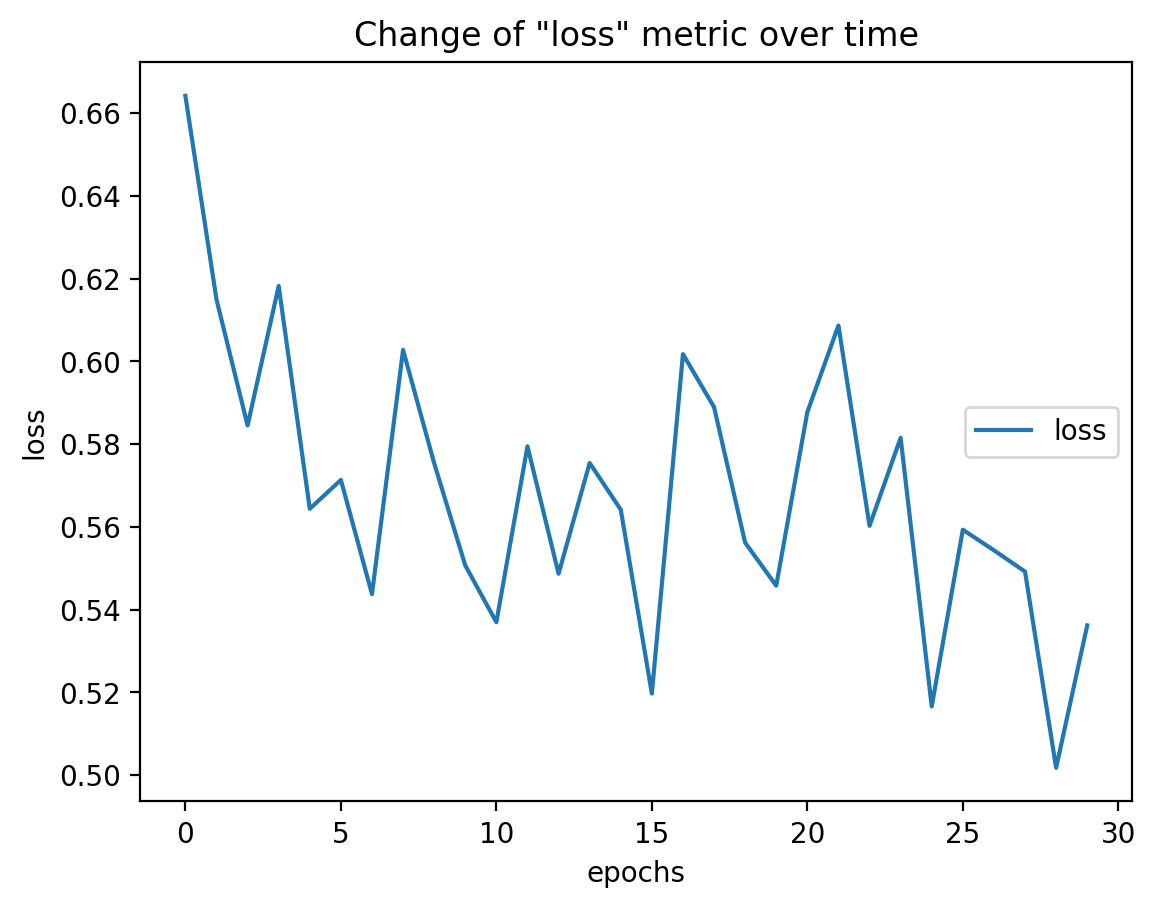

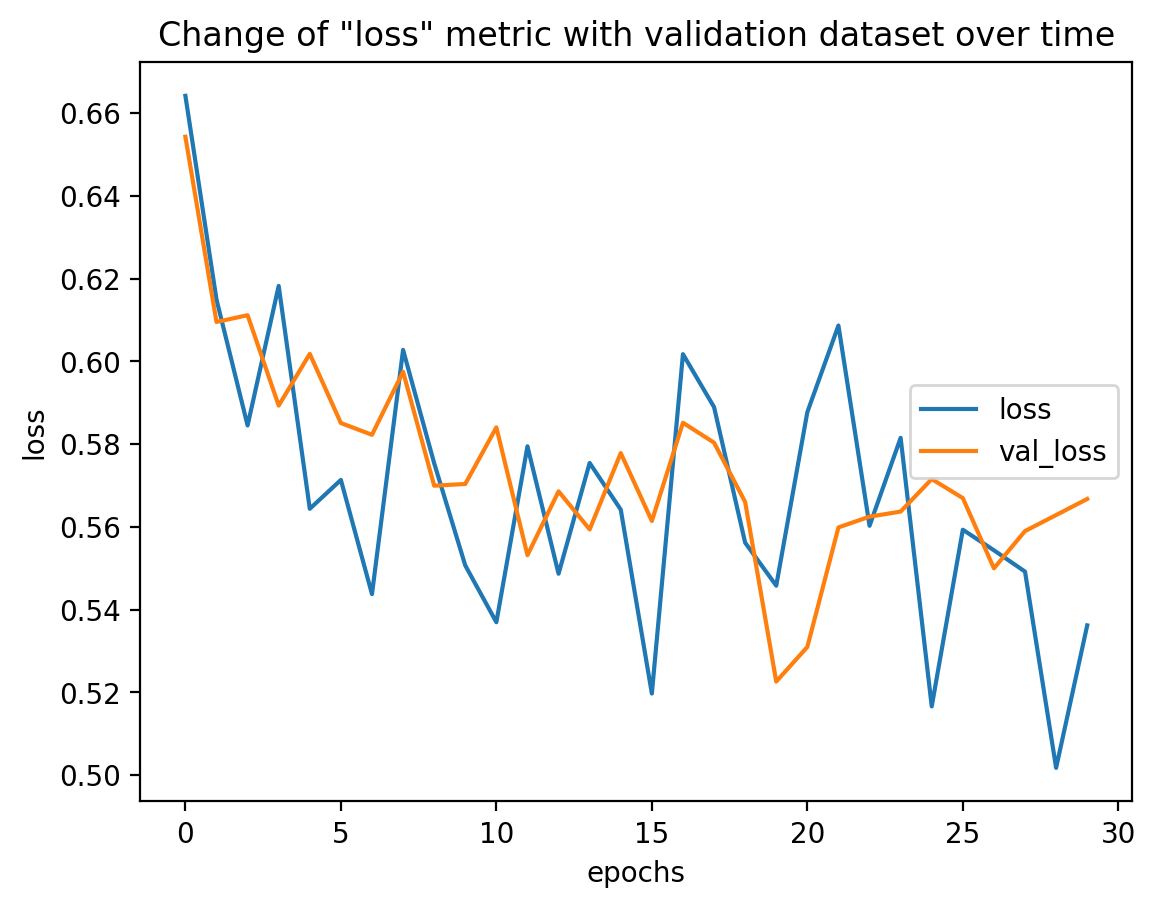

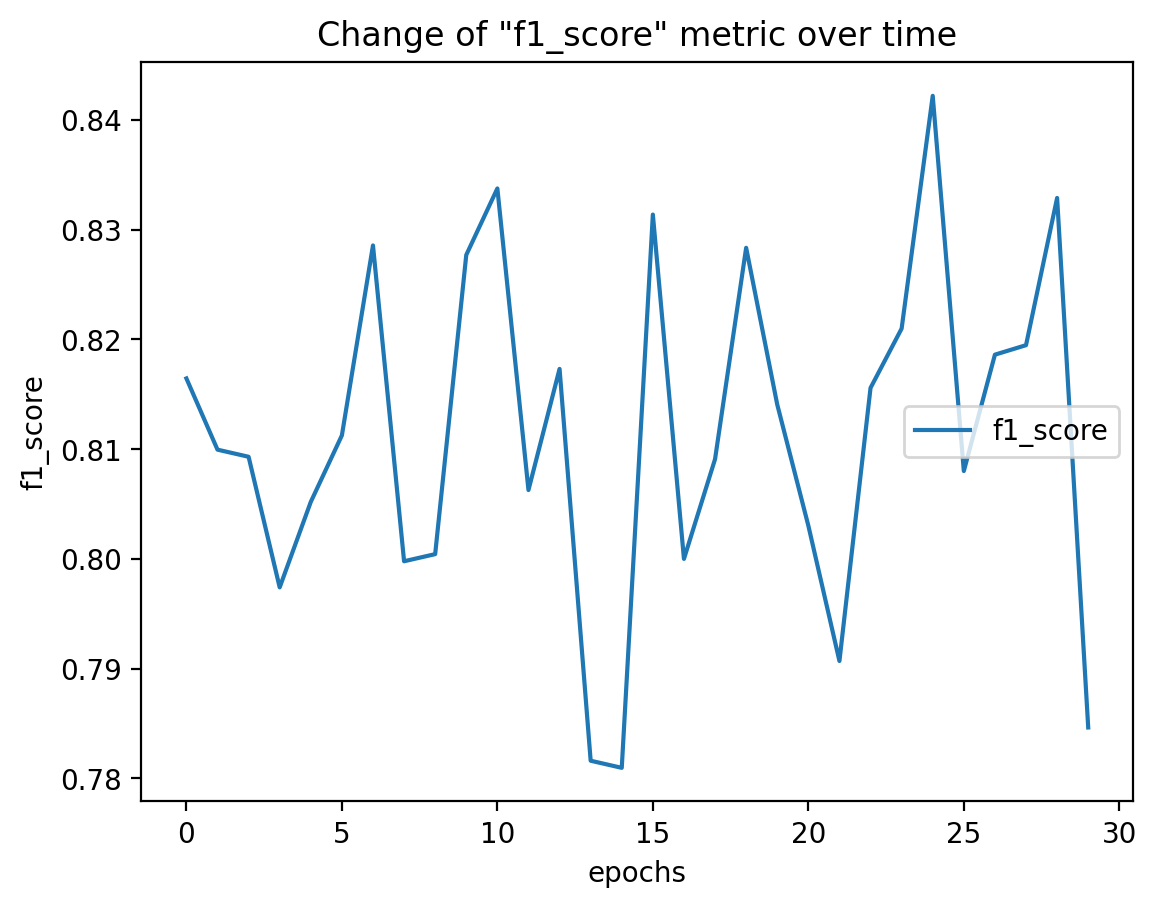

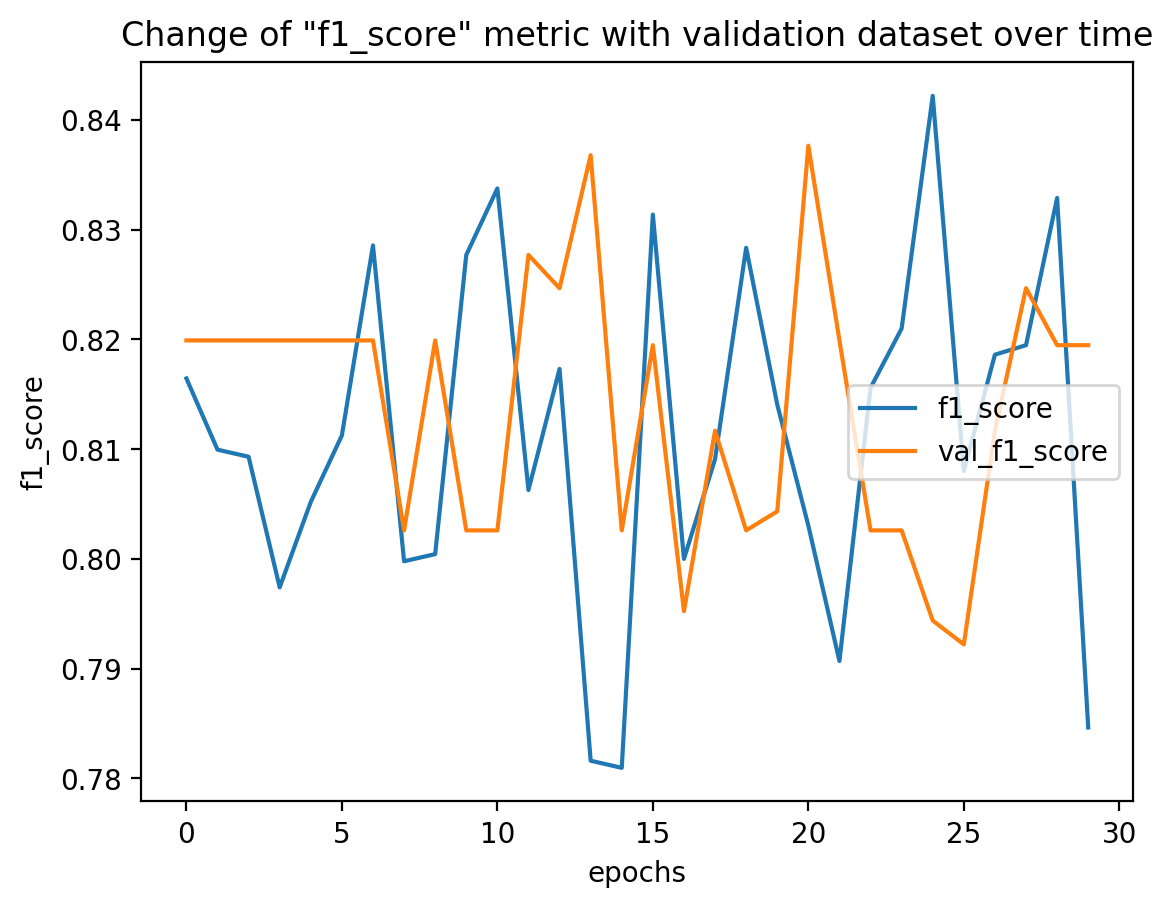


Confusion Matrix:
	---------------------------------
	|	30	|	2	| 
	---------------------------------
	|	9	|	3	|
	---------------------------------

TruePositive	:	30
TrueNegative	:	3
FalsePositive	:	2
FalseNegative	:	9


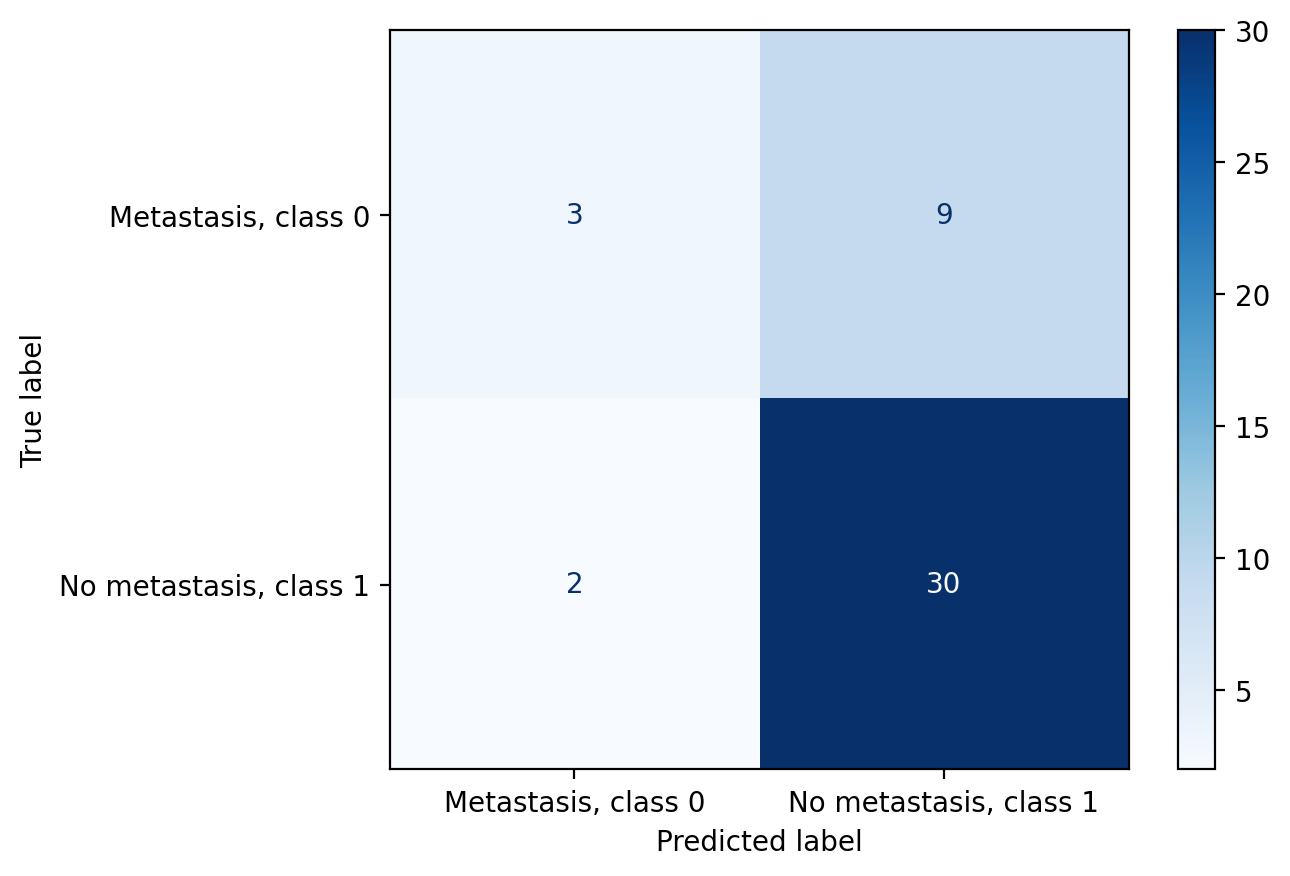

                        precision    recall  f1-score   support

   Metastasis, class 0       0.60      0.25      0.35        12
No metastasis, class 1       0.77      0.94      0.85        32

              accuracy                           0.75        44
             macro avg       0.68      0.59      0.60        44
          weighted avg       0.72      0.75      0.71        44



In [5]:
metric_names = model.metrics_names
scores = model.evaluate(testData, y_test, verbose=0)

print("Metrics:")
for i, name in enumerate(metric_names):
    print("\t%s:   \t%.2f" % (name, scores[i]))

def plot_metric(metric: str, withVal: bool = False) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.xlabel("epochs")
    plt.ylabel(metric)

    ax.plot(results.history[metric], label=metric)
    if withVal:
        plt.title(f'Change of "{str(metric)}" metric with validation dataset over time')
        ax.plot(results.history["val_" + str(metric)], label="val_" + str(metric))
    else:
        plt.title(f'Change of "{metric}" metric over time')
    plt.legend(loc="center right")
    plt.show(block=False)

for name in metric_names:
    plot_metric(name)
    if withVal:
        plot_metric(name, withVal)

predictions = (model.predict(testData, verbose=0) > 0.5).astype("int32")

conf_mat = confusion_matrix(y_test, predictions)
confusion = {
    "TruePositive": conf_mat[1][1],
    "TrueNegative": conf_mat[0][0],
    "FalsePositive": conf_mat[1][0],
    "FalseNegative": conf_mat[0][1],
}
accuracy = scores[1]
accuracy = round(accuracy * 100, 2)

def printDict(obj: dict[str, int] = "") -> None:
    if isinstance(obj, dict):
        for k, v in obj.items():
            if hasattr(v, "__iter__"):
                print(k)
                printDict(v)
            else:
                print("%s\t:\t%s" % (k, v))
    elif isinstance(obj, list):
        for v in obj:
            if hasattr(v, "__iter__"):
                printDict(v)
            else:
                print(v)
    else:
        print(obj)

separator = "\t---------------------------------\n"
matrixConfusion = f'\nConfusion Matrix:\n{separator}\t|\t{confusion["TruePositive"]}\t|\t{confusion["FalsePositive"]}\t| \n{separator}\t|\t{confusion["FalseNegative"]}\t|\t{confusion["TrueNegative"]}\t|\n{separator}'
print(matrixConfusion)
printDict(confusion)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=TARGET_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(y_test, predictions, target_names=TARGET_NAMES)
print(report)
